# Clustering of univariate data via Dirichlet Process Mixture

this is a continuation of 'estimate_univ_density'. Make sure to check it before going through this tutorial!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pybmix.core.mixing import DirichletProcessMixing, StickBreakMixing
from pybmix.core.hierarchy import UnivariateNormal
from pybmix.core.mixture_model import MixtureModel

np.random.seed(2021)

## DP and clustering

Recall that $\tilde p \sim DP(\alpha, G_0)$ means that $\tilde p = \sum_{h=1}^\infty w_h \delta_{\tau_h}$ with $\{w_h\}_h \sim GEM(\alpha)$ and $\{\tau_h\}_h \sim G_0$. Hence, realizations from a DP are almost surely discrete probability measures.

Hence, sampling 

\begin{equation}
\begin{aligned}
\theta_1, \ldots, \theta_n | \tilde{p} & \sim \tilde{p} \\
\tilde{p} &\sim DP(\alpha, G_0)
\end{aligned}
\end{equation}


entails that with positive probability $\theta_i = \theta_j$ (with $i \neq j$). In a sample of size $n$ there will be $k \geq n$ unique values $\theta^*_1, \ldots, \theta^*_k$ among the $\theta_i$'s and clusters are defined as $C_j = \{i : \theta_i = \theta^*_j \}$.

When considering a mixture model, the $\theta_i$'s are not observations but latent variables. In the case of a univariate normal mizture models, $\theta_i = (\mu_i, \sigma^2_i)$ and the model can be written as

\begin{equation}
\begin{aligned}
    y_i | \theta_i = (\mu_i, \sigma^2_i) &\sim \mathcal N(\mu_i, \sigma^2_i) \\
    \theta_1, \ldots, \theta_n | \tilde{p} &\sim \tilde{p} \\
    \tilde{p} &\sim DP(\alpha, G_0)
\end{aligned}
\end{equation}

and the clustering among the observations $y_i$'s is inherited by the clustering among the $\theta_i$'s.

Let's go back to the previous example

In [2]:
def sample_from_mixture(weigths, means, sds, n_data):
    n_comp = len(weigths)
    clus_alloc = np.random.choice(np.arange(n_comp), p=[0.5, 0.5], size=n_data)
    return np.random.normal(loc=means[clus_alloc], scale=sds[clus_alloc])

y = sample_from_mixture(
    np.array([0.5, 0.5]), np.array([-3, 3]), np.array([1, 1]), 200)

mixing = DirichletProcessMixing(total_mass=5)
hierarchy = UnivariateNormal()
hierarchy.make_default_fixed_params(y, 2)
mixture = MixtureModel(mixing, hierarchy)

mixture.run_mcmc(y, algorithm="Neal2", niter=2000, nburn=1000)

Initializing... Done
Running Neal2 algorithm with NNIG hierarchies, DP mixing...
==>                                                       ] 8% 0.1s[====>                                                       ] 8% 0.101s[====>                                                       ] 8% 0.102s[=====>                                                      ] 8% 0.103s[=====>                                                      ] 8% 0.104s[=====>                                                      ] 8% 0.105s[=====>                                                      ] 8% 0.106s[=====>                                                      ] 8% 0.106s[=====>                                                      ] 8% 0.107s[=====>                                                      ] 8% 0.108s[=====>                                                      ] 9% 0.108s[=====>                                                      ] 9% 0.109s[=====>                                                     

We can extract the cluster allocation MCMC chain very easily

In [3]:
mcmc_chain = mixture.get_chain()
cluster_alloc_chain = mcmc_chain.extract("cluster_allocs")
print(cluster_alloc_chain.shape)

(1000, 200)


cluster_alloc_chain is a matrix of shape [niter - nburn, ndata]. 

To get the posterior distribution of the number of clusters, we count in each row the number of unique values

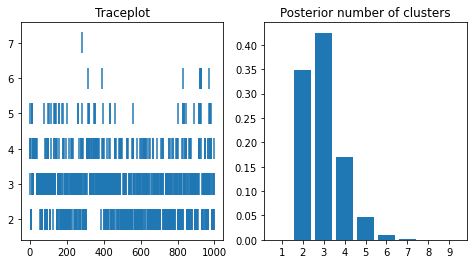

In [4]:
n_clust_chain = np.apply_along_axis(lambda x: len(np.unique(x)), 1, 
                                    cluster_alloc_chain)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].vlines(np.arange(len(n_clust_chain)), n_clust_chain - 0.3, n_clust_chain + 0.3)
axes[0].set_title("Traceplot")

clusgrid = np.arange(1, 10)
probas = np.zeros_like(clusgrid)
for i, c in enumerate(clusgrid):
    probas[i] = np.sum(n_clust_chain == c)

probas = probas / np.sum(probas)
axes[1].bar(clusgrid, probas)
axes[1].set_xticks(clusgrid)
axes[1].set_title("Posterior number of clusters")
    
plt.show()

Let's inspect two iterations: the first one and the last one, and look at the cluster allocations of the first 5 observations

In [5]:
print("First iteration: ", cluster_alloc_chain[0][:5])
print("Last iteration: ", cluster_alloc_chain[-1][:5])

First iteration:  [0 0 1 1 0]
Last iteration:  [1 1 0 0 1]


Observe that the clustering are identicals: the one is made of observations $\{1, 2, 5\}$ and the other cluster of observations $\{3, 4\}$. However the labels associated to each cluster are differend depending on the iterations: in the first iteration, $\{1, 2, 5\}$ are the first cluster (0th cluster) and  $\{3, 4\}$ are the second cluster, while in the last iteration the opposite happens.

This is due to the so-called "label-switching". Usually to interpret the clustering result, a suitable point-estimate is chosen to minimize a loss function.

(Computing mean dissimilarity... Done)
===========>                                               ] 20% 0.1s[============>                                               ] 20% 0.101s[============>                                               ] 20% 0.102s[============>                                               ] 20% 0.102s[============>                                               ] 20% 0.103s[============>                                               ] 21% 0.104s[============>                                               ] 21% 0.105s[============>                                               ] 21% 0.105s[=============>                                              ] 21% 0.106s[=============>                                              ] 21% 0.107s[=============>                                              ] 22% 0.107s[=============>                                              ] 22% 0.108s[=============>                                              ] 22% 0.109s[=============> 

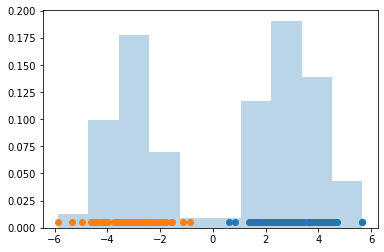

In [6]:
from pybmix.estimators.cluster_estimator import ClusterEstimator

clus_est = ClusterEstimator(mixture)
best_clust = clus_est.get_point_estimate()

plt.hist(y, density=True, alpha=0.3)
for cluster_idx in clus_est.group_by_cluster(best_clust):
    data = y[cluster_idx]
    plt.scatter(data, np.zeros_like(data) + 5e-3)
    
plt.show()

Note how the posterior mode of the number of clusters is 3, but the point estimate for the best clustering consists of 2 clusters